In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from skimage.io import imread
%matplotlib inline

In [2]:
def loadImg(imgPath):
    """
    Returns the all bgr/rgb/gray types of image for same image file.
    
    Parameters
    ----------
    imgPath : input image path

    Returns
    -------
    imgBGB, imgRGB and imgGray: 3 types of image
    """
    imgBGR = cv2.imread(imgPath)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    imgGray = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
    
    return imgBGR, imgRGB, imgGray
    
imgBGR, imgRGB, imgGray = loadImg('./lena.png')

print('The image height is %d, width is %d'%(imgBGR.shape[0], imgBGR.shape[1]), ', and each image data item occupies %d bits'%(8*imgBGR.itemsize))
print('After converting, the image data type is', imgBGR.dtype)


The image height is 512, width is 512 , and each image data item occupies 8 bits
After converting, the image data type is uint8


这意味着可以将之显示为三维模型，三个轴分别为Y坐标，X坐标，像素亮度。 下面展示了用matplotlib进行3D绘图的基础：

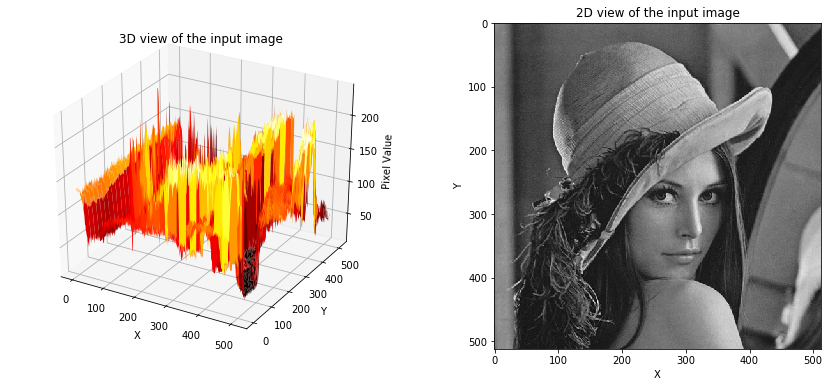

In [3]:
def show3DImageView(imgGray):
    """
    Show the input gray image in 3D and 2D view
    
    Parameters
    ----------
    imgGray: input grayscale image

    Returns
    -------
    None
    """
    H, W = imgGray.shape
    xrange=np.arange(W)
    yrange=np.arange(H)
    ypos, xpos = np.meshgrid(yrange, xrange, indexing='ij')
    imgVal = imgGray[ypos, xpos]

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121, projection='3d', navigate=True)
    ax.plot_surface(xpos, ypos, imgVal, cmap="hot",rstride=20,cstride=20)
    plt.title('3D view of the input image')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Pixel Value')
    ax = fig.add_subplot(1,2, 2)
    ax.imshow(imgGray, cmap="gray")
    plt.title('2D view of the input image')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()
    
show3DImageView(imgGray)


对图像进行各种各样的点操作来的到有趣的结果，下面是一些实现。注意：必须确保图像的值域和类型可以满足转换的需要，否则得到的结果图像会出错

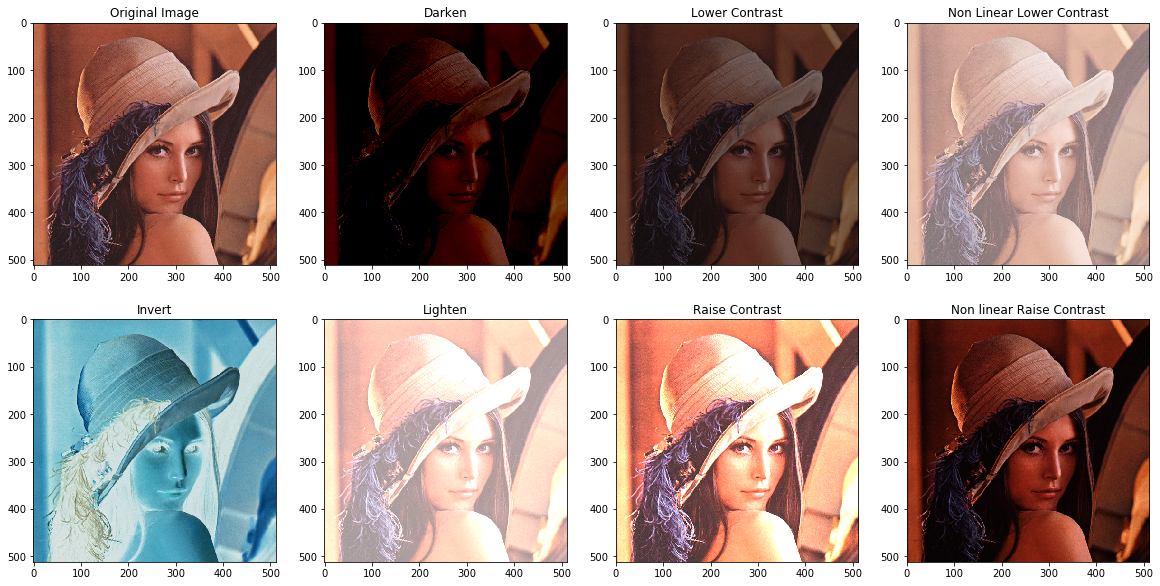

In [4]:
def convertImgs(imgList):
    """
    Make sure every image in input imgList is in range [0 255], and is np.uint8
    
    Parameters
    ----------
    imgList: input image list

    Returns
    -------
    An input image list. Every image in this list is in range [0 255], and is np.uint8
    """
    newImgList=[]
    for im in imgList:
        im[im>255] = 255
        im[im<0] = 0
        im = im.astype(np.uint8)
        newImgList.append(im)
    
    return newImgList

def pixelProcess(imgIn):
    """
    Different point processing to input image
    
    Parameters
    ----------
    imgIn: input image

    Returns
    -------
    An input image list handled by different point processing operations.
    """
    imgInF = imgIn.astype(np.float32)
    
    darkenImg = imgInF - 128
    lowerContrastImg = (imgInF / 2).astype(np.uint8)    
    nonLinearLCImg = (imgInF/255)**(1/3) * 255    
    invertImg = 255 - imgInF    
    lightenImg = imgInF + 128    
    raiseContrastImg = imgInF * 2    
    nonLinearRCImg = (imgInF/255)**2 * 255
        
    return [imgIn, darkenImg, lowerContrastImg, nonLinearLCImg, invertImg, lightenImg, raiseContrastImg, nonLinearRCImg]

def showPixelProcessResult(imgList):
    """
    Show images in input imgList
    
    Parameters
    ----------
    imgList: An input image list. Every image in this list is in range [0 255], and is np.uint8

    Returns
    -------
    None
    """
    titleList=['Original Image', 'Darken', 'Lower Contrast', 'Non Linear Lower Contrast', 
               'Invert', 'Lighten', 'Raise Contrast', 'Non linear Raise Contrast']
    plt.figure(figsize=(20,10))
    for i in range(len(imgList)):
        plt.subplot(2, 4, i+1)
        plt.imshow(imgList[i], cmap="gray")
        plt.title(titleList[i])
    
    plt.show()
    
imgList = pixelProcess(imgRGB)
imgList = convertImgs(imgList)
showPixelProcessResult(imgList)

线性移不变图像滤波器

In [5]:
from scipy.ndimage.filters import convolve
import time
def myBoxFilter(imgIn, ksize=(3,3)):
    """
    An implementation of box filter by python
    
    Parameters
    ----------
    imgIn: An input image which might be 3 channel RGB image or 1 channel grayscale image.

    Returns
    -------
    Filtered image, same type as input image
    """
    kernel = np.ones(ksize)
    kernel = kernel/kernel.sum()
    imgOut = np.zeros(imgIn.shape, np.float64)
    imgInF = imgIn.astype(np.float64)
    if len(imgIn.shape)==2:
        imgOut = convolve(imgInF, kernel)
    elif len(imgIn.shape)==3:
        for c in range(3):
            slice=imgInF[:,:, c]
            imgOut[:,:,c] = convolve(slice, kernel)
    else:
        raise('Input Image Error!')
        
    imgOut = imgOut.astype(np.uint8)
    
    return imgOut
    
start = time.clock()    
imgFiltered = myBoxFilter(imgRGB, (7, 7))
end = time.clock()
myDur = end - start

In [6]:
def compareImg(leftImg, rightImg, roi, leftTitle, rightTitle):
    """
    Compare input image pair, showing full images and the ROIs
    
    Parameters
    ----------
    leftImg, rightImg: left image and right image to compare
    roi: list of [top, bottom, left, right, extend] of ROI
    leftTitle, rightTitle: figure titles

    Returns
    -------
    Filtered image, same type as input image
    """
    cmap="gray"    
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(leftImg,cmap)
    plt.title(leftTitle)

    plt.subplot(2,2,2)
    plt.imshow(rightImg,cmap)
    plt.title(rightTitle)
    
    ax = plt.subplot(2, 2, 3)
    top, bottom, left, right, extend = roi
    rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
    ax.add_patch(rect)    
    plt.imshow(leftImg,cmap)
    plt.ylim(bottom+extend, top-extend)
    plt.xlim(left-extend, right+extend)
    plt.title("ROI of " + leftTitle)
    
    ax = plt.subplot(2, 2, 4)
    top, bottom, left, right, extend = roi
    rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
    ax.add_patch(rect)    
    plt.imshow(rightImg,cmap)
    plt.ylim(bottom+extend, top-extend)
    plt.xlim(left-extend, right+extend)
    plt.title("ROI of " + rightTitle)

    plt.show()    

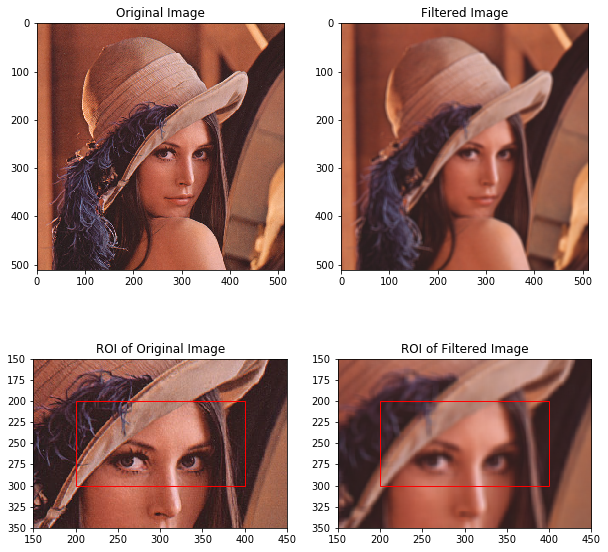

In [7]:
roi = [200, 300, 200, 400, 50]    
compareImg(imgRGB, imgFiltered, roi, "Original Image", "Filtered Image")

In [8]:
start = time.clock()
imgFilteredCV = cv2.boxFilter(imgRGB, ddepth=-1, ksize=(7, 7), borderType=cv2.BORDER_REFLECT)
end = time.clock()
cvDur = end - start

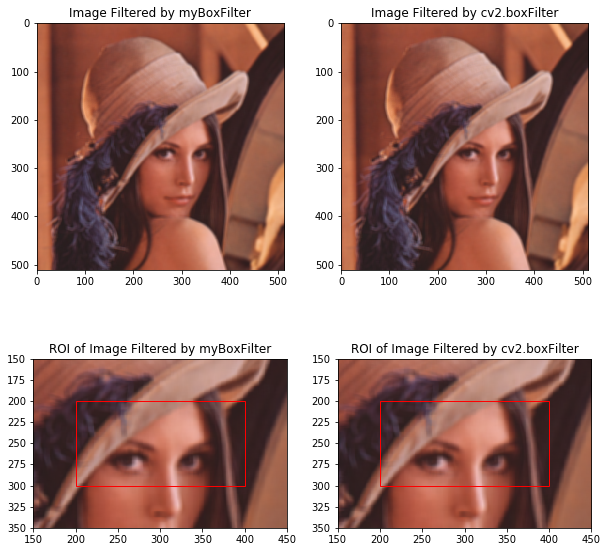

In [9]:
compareImg(imgFiltered, imgFilteredCV, roi, "Image Filtered by myBoxFilter", "Image Filtered by cv2.boxFilter")

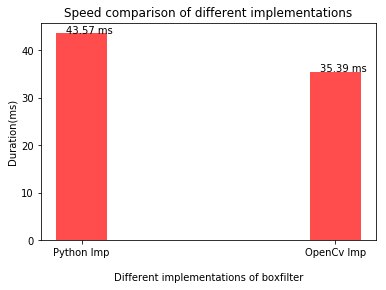

In [11]:
dur_list = [myDur*1000,cvDur*1000]
fig, ax = plt.subplots()
bar_width=0.2
index=np.arange(len(dur_list))
rects1 = ax.bar(index, dur_list, bar_width,
                alpha=0.7, color='red',
                label='Men')

for i in range(len(rects1)):
    r = rects1[i]
    top = r.get_height()
    xloc = r.get_x() + r.get_width()/2-0.06
    ax.text(xloc, top, "%.2f ms"%dur_list[i])
ax.set_xticks(index )
ax.set_xticklabels(('Python Imp', 'OpenCv Imp'))
ax.set_ylabel("Duration(ms)")
ax.set_xlabel("\nDifferent implementations of boxfilter")
ax.set_title("Speed comparison of different implementations")
plt.show()

之所以速度差异如此大，很重要原因是OpenCV采用了分离式卷积，将boxFilter变成了两个一维的卷积，所以也可以来改进自己的实现:

In [12]:
from scipy.ndimage.filters import convolve1d
def myBoxFilterSep(imgIn, ksize=(3,3)):
    """
    An implementation of box filter by python by seperate 1D convolve
    
    Parameters
    ----------
    imgIn: An input image which might be 3 channel RGB image or 1 channel grayscale image.

    Returns
    -------
    Filtered image, same type as input image
    """
    kernel = np.ones((ksize[1], 1)).flatten()
    kernel /= kernel.sum()
    imgOut = np.zeros(imgIn.shape, np.float32)
    imgInF = imgIn.astype(np.float32)
    if len(imgIn.shape)==2:
        imgOut = convolve1d(imgInF, kernel, axis=0)
        imgOut = convolve1d(imgOut, kernel, axis=1)
    elif len(imgIn.shape)==3:
        for c in range(3):
            slice=imgInF[:,:, c]
            slice = convolve1d(slice, kernel, axis=0)
            imgOut[:,:,c] = convolve1d(slice, kernel, axis=1)
    else:
        raise('Input Image Error!')
        
    imgOut = imgOut.astype(np.uint8)
    
    return imgOut
    
start=time.clock()    
imgFilteredSep = myBoxFilterSep(imgRGB, (7, 7))
end=time.clock()
my1DDur = end - start

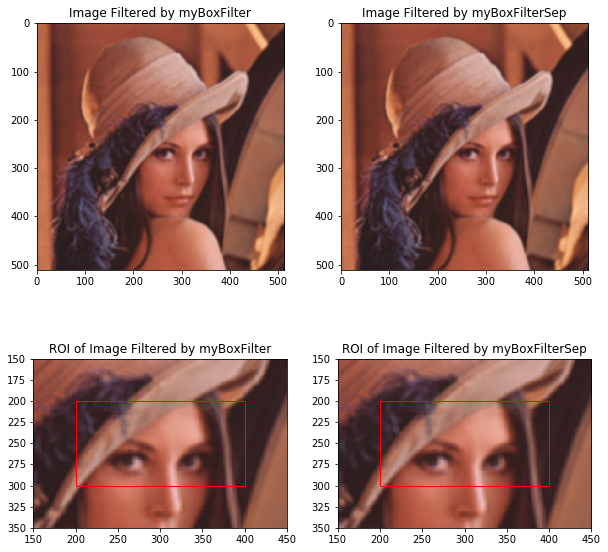

In [14]:
compareImg(imgFiltered, imgFilteredSep, roi, "Image Filtered by myBoxFilter", "Image Filtered by myBoxFilterSep")

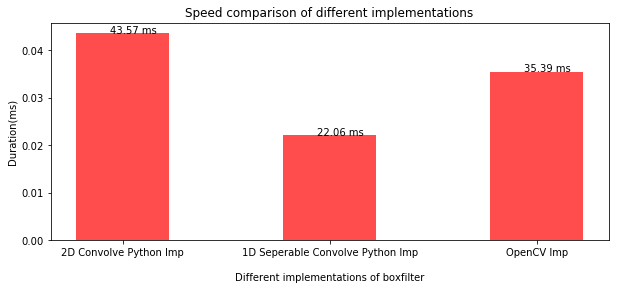

In [15]:
dur_list = [myDur,my1DDur, cvDur]
fig, ax = plt.subplots(figsize=(10,4))
bar_width=0.45
index=np.arange(len(dur_list))
rects1 = ax.bar(index, dur_list, bar_width,
                alpha=0.7, color='red',
                label='Men')

for i in range(len(rects1)):
    r = rects1[i]
    top = r.get_height()
    xloc = r.get_x() + r.get_width()/2-0.06
    ax.text(xloc, top, "%.2f ms"%(1000 * dur_list[i]))
ax.set_xticks(index )
ax.set_xticklabels(('2D Convolve Python Imp', '1D Seperable Convolve Python Imp', 'OpenCV Imp'))
ax.set_ylabel("Duration(ms)")
ax.set_xlabel("\nDifferent implementations of boxfilter")
ax.set_title("Speed comparison of different implementations")
plt.show()

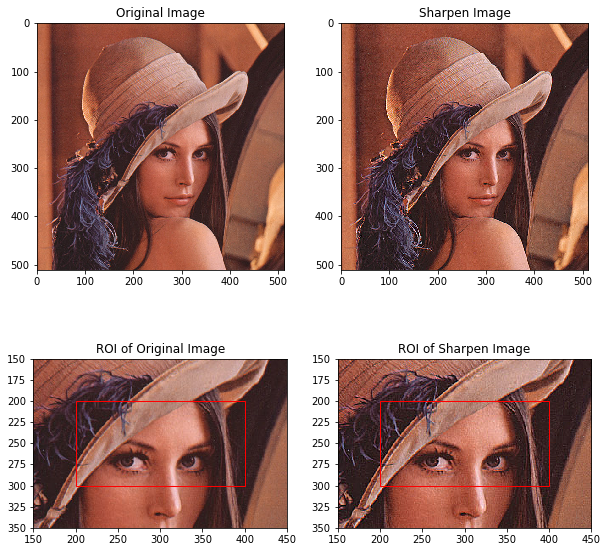

In [16]:
kernel = -np.ones((3, 3))/9
kernel[1,1]+=2

imgSharp = np.zeros(imgRGB.shape)
for c in range(3):
    imgSharp[:,:,c] = convolve(imgRGB[:,:,c].astype(np.float64), kernel)
[imgSharp]=convertImgs([imgSharp])    
    
compareImg(imgRGB, imgSharp, roi, "Original Image", "Sharpen Image")

下面的例子形象的展示了水平和垂直Sobel梯度，可以看出水平梯度产生垂直的边缘，而垂直梯度产生水平的边缘

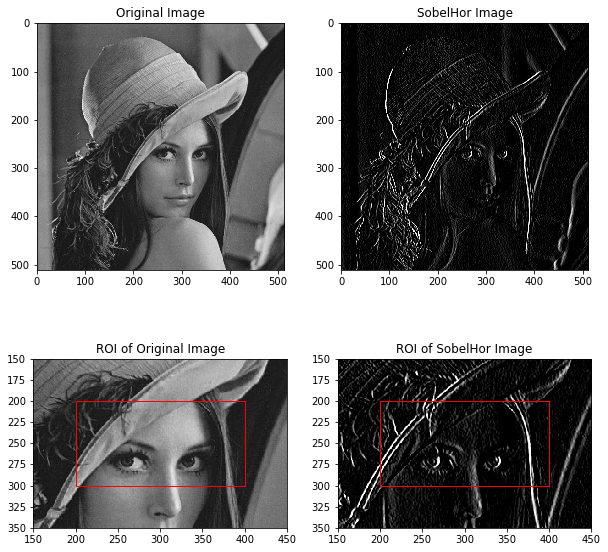

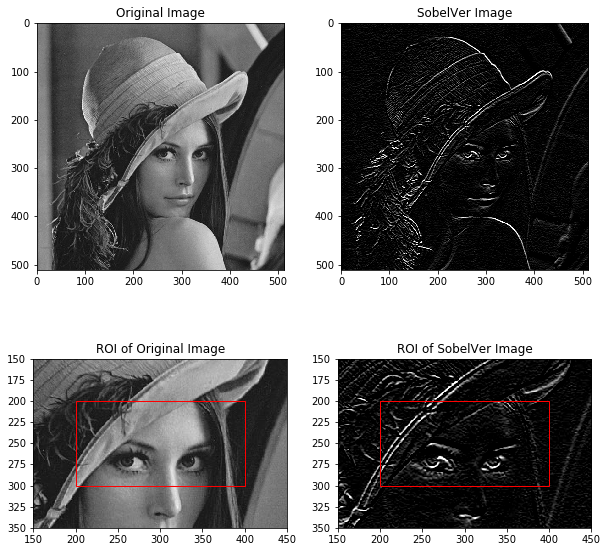

In [17]:
def edgeFilter(img, kernel, name=""):
    imgOut = np.zeros(img.shape)
    if len(img.shape)==3:
        for c in range(3):
            imgOut[:,:,c] = convolve(img[:,:,c].astype(np.float64), kernel)
    else:
        imgOut = convolve(img.astype(np.float64), kernel)
    [imgOut]=convertImgs([imgOut])  
    return imgOut

SobelHor = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
SobelVer = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

sobels=[SobelHor, SobelVer]
names = ["SobelHor", "SobelVer"]

for sid in range(len(sobels)):
    imgOut = edgeFilter(imgGray, sobels[sid], names[sid])
    compareImg(imgGray, imgOut, roi, "Original Image", "%s Image"%names[sid])

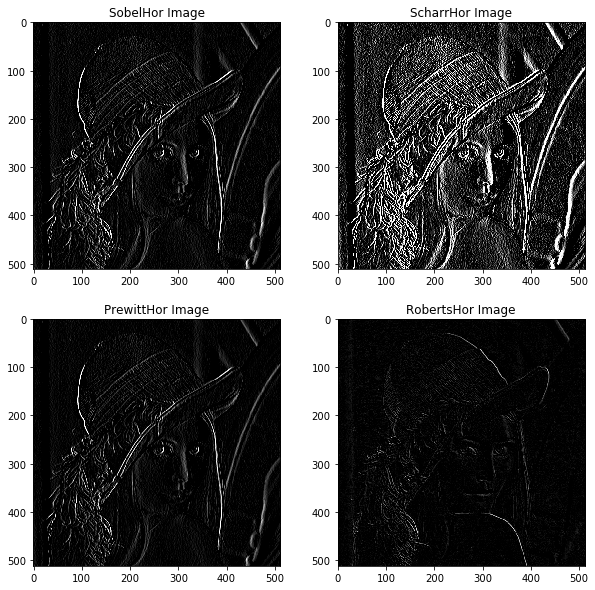

In [18]:
ScharrHor = np.array([[3,0,-3],[10,0,-10],[3,0,-3]])
PrewittHor = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
RobertsHor = np.array([[0,1],[-1,0]])

filters=[SobelHor,ScharrHor, PrewittHor, RobertsHor]
names = ["SobelHor", "ScharrHor", "PrewittHor", "RobertsHor"]

plt.figure(figsize=(10,10))
for sid in range(len(filters)):
    imgOut = edgeFilter(imgGray, filters[sid], names[sid])
    plt.subplot(2,2,sid+1)
    plt.imshow(imgOut,cmap="gray")
    plt.title("%s Image"%names[sid])
plt.show()


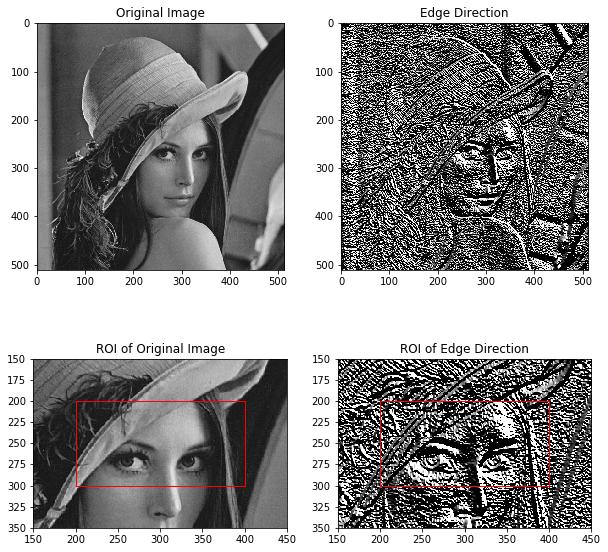

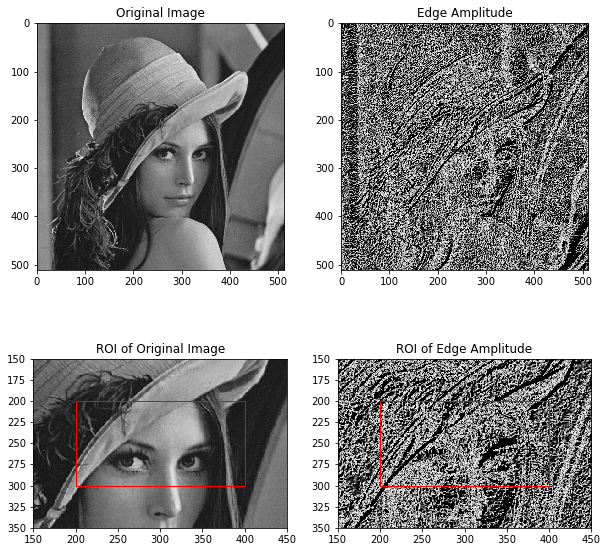

In [19]:
sobelX = edgeFilter(imgGray, SobelHor, "SobelHor")
sobelY = edgeFilter(imgGray, SobelVer, "SobelVer")

tan = sobelY/(sobelX+1e-4)
theta = np.arctan(tan)
amp = np.sqrt(sobelX**2 + sobelY**2).astype(np.float64)
compareImg(imgGray, theta, roi, "Original Image", "Edge Direction")
compareImg(imgGray, amp, roi, "Original Image", "Edge Amplitude")

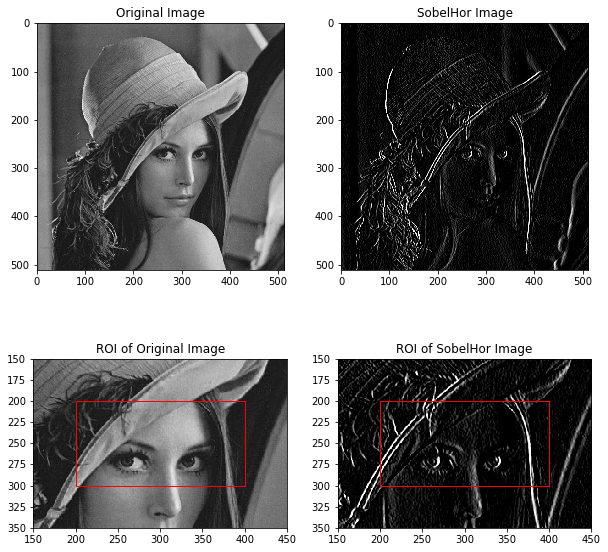

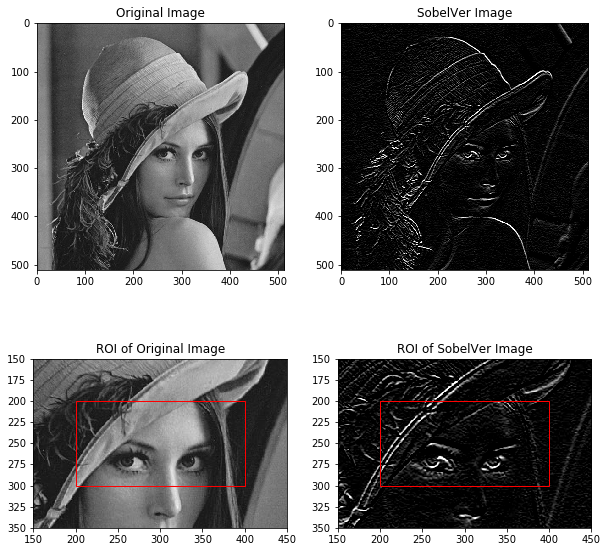

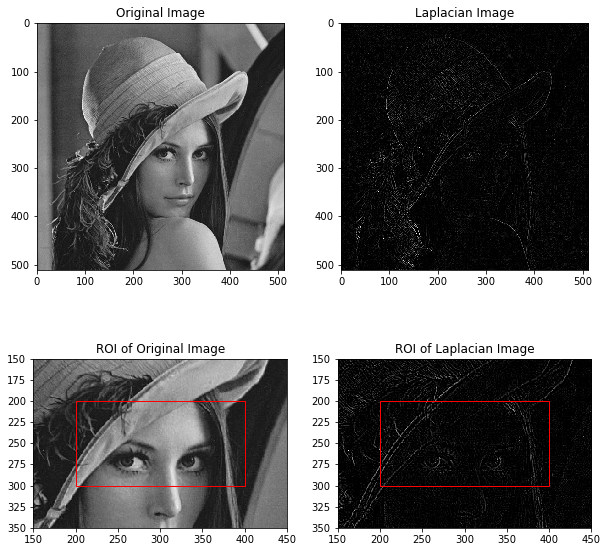

In [20]:
roi = [200, 300, 200, 400, 50]  
LapKernel = -1 * np.array([[0,1,0],[1,-4,1],[0,1,0]])
kenels=[SobelHor, SobelVer, LapKernel]
names = ["SobelHor", "SobelVer", "Laplacian"]

for sid in range(len(kenels)):
    imgOut = edgeFilter(imgGray, kenels[sid], names[sid])
    compareImg(imgGray, imgOut, roi, "Original Image", "%s Image"%names[sid])

DOG&LOG

In [21]:
from scipy.ndimage import gaussian_filter, gaussian_laplace
roi = [100, 130, 300, 350, 10]  
imgDoG = gaussian_filter(imgGray.astype(np.float64), 2, (1, 1))
imgLoG = gaussian_laplace(imgGray.astype(np.float64), 2)

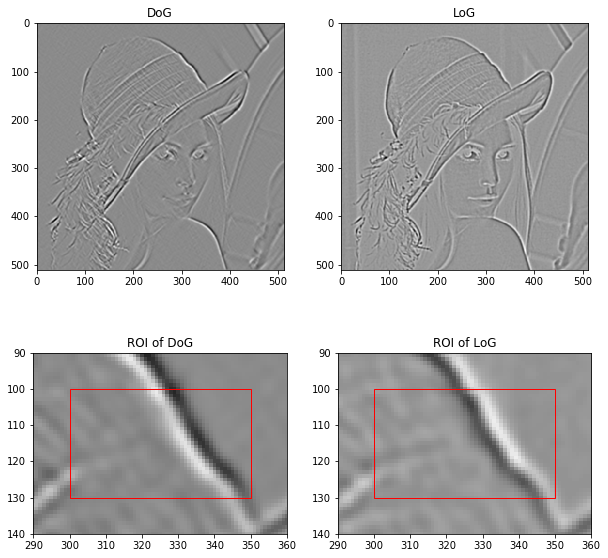

In [22]:
compareImg(imgDoG, imgLoG, roi, "DoG", "LoG")